# Clutering

- for online store we want to cluster it's customers into different groups, so that we can run targeted campaigns for each group. 
- the data for the online store we have is order level details. 
- so, first we need to aggregate the order level details to customer level details 
- for each customer we need to have the attributes depending on which we will do clustering. 
- a common practice in the field of marketing is to group the customers in terms of RFM analysis. 
- R stands for Recency: How recently did the customer purchase. 
- F stands for Frequency: How frequently did they purchase. 
- M stands for Monetory Value: How much do they spend. 
- R = 30 means a customer has not purchased anything in last 30 days. 
- F = 50 means a customer has made 50 purchases in the last year. 
- M gives the total amount of the purchases made by the customer in last one year. 
- thus we need to transform the data from orderwise to these RFM attributes for each customer. 

## Data Preparation Steps 
- importing the dataset: where each row will represent the order having the unique invoice number. 
- Removing missing values
- Aggregate RFM values: transform the data to customer wise to compute the RFM
- Outlier Treatment: outliers impact the clustering in the k-means algorithm. 

**Overview** 
One retail is a trannationational dataset which contails all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK based and registered non -store online retail. The company mainly sells unique all occasion givts. Many customer fo the company are wholesalers. 

## The Steps are broadly: 
1. Read and understand the data 
2. Clean the data 
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendations

## 1. Read and understand the data 


In [1]:
# importing the dataset 
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container{width: 90% !important}</style>"))
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# loading dataset
retail_df = pd.read_csv('Online+Retail.csv', sep = ',', encoding='ISO-8859-1', header= 0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# basics of the df
retail_df.shape

(541909, 8)

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 2. Clean the data

In [5]:
# missing values 
round(((retail_df.isnull().sum()/ len(retail_df))*100),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# drop all rows having missing values 
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [7]:
# new columns: amount
retail_df['Amount'] = retail_df.Quantity* retail_df.UnitPrice
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## 3. Prepare the data for modelling


- R stands for Recency: How recently did the customer purchase. 
- F stands for Frequency: How frequently did they purchase. 
- M stands for Monetory Value: How much do they spend. 
- R = 30 means a customer has not purchased anything in last 30 days. 
- F = 50 means a customer has made 50 purchases in the last year. 
- M gives the total amount of the purchases made by the customer in last one year. (revenue contributed)

So in this case, we need to transform dataset into 4 cols, customer id, recency, frequecy and monetory value

In [8]:
# monetory value
grouped_df = retail_df.groupby('CustomerID')['Amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
# merge the two dataframe
grouped_df = pd.merge(grouped_df, frequency, on = 'CustomerID', how = 'inner')
grouped_df.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [11]:
# recency 

retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],
                                         format = '%d-%m-%Y %H:%M')

In [12]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [13]:
# compute the max date 
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# compute the diff between each transaction & max date
retail_df['diff'] = max_date - retail_df.InvoiceDate
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# finally ready to create recency col 
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [16]:
grouped_df = pd.merge(grouped_df, last_purchase, on = 'CustomerID', how = 'inner')
grouped_df.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [17]:
# number of days only
grouped_df['Recency'] = grouped_df.Recency.dt.days
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


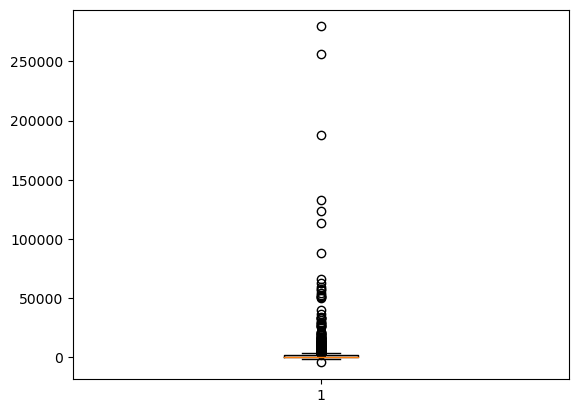

In [18]:
# outlier treatment 
plt.boxplot(grouped_df['Amount'])
plt.show()

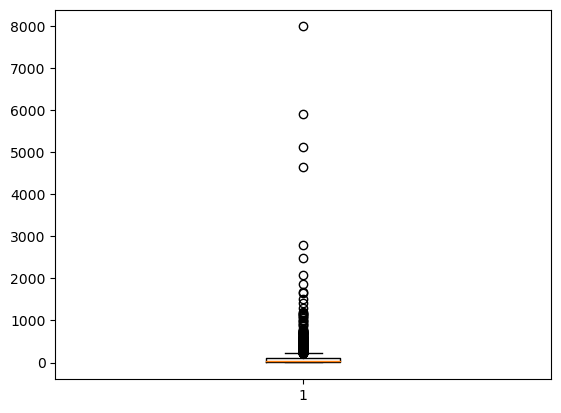

In [19]:
plt.boxplot(grouped_df['Frequency'])
plt.show()

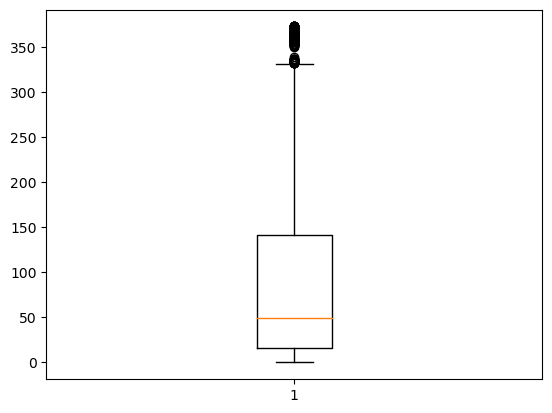

In [20]:
plt.boxplot(grouped_df['Recency'])
plt.show()

In [21]:
# removing statistical outliers

# for amount

q1 = grouped_df.Amount.quantile(0.05)
q3 = grouped_df.Amount.quantile(0.95)

IQR = q3 - q1
grouped_df = grouped_df[(grouped_df.Amount >= (q1-(1.5*IQR)))& (grouped_df.Amount <= (q3 +( 1.5*IQR)))]



In [22]:
# for frequency

q1 = grouped_df.Frequency.quantile(0.05)
q3 = grouped_df.Frequency.quantile(0.95)

IQR = q3 - q1
grouped_df = grouped_df[(grouped_df.Frequency >= (q1-(1.5*IQR))) & (grouped_df.Frequency <= (q3 +( 1.5*IQR)))]



In [23]:
# for recency

q1 = grouped_df.Recency.quantile(0.05)
q3 = grouped_df.Recency.quantile(0.95)

IQR = q3 - q1
grouped_df = grouped_df[(grouped_df.Recency >= (q1-(1.5*IQR))) & (grouped_df.Recency <= (q3 +( 1.5*IQR)))]



In [24]:
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [25]:
# rescaling 
rfm_df = grouped_df[['Amount', 'Frequency', 'Recency']]

# instantiate 
scaler = StandardScaler()

#fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## 4. Modelling

In [26]:
# modelling

In [27]:
# chosing the arbitrary value of k

In [28]:
# k-means with some arbitrary k 
kmeans = KMeans(n_clusters= 4, max_iter= 50 )
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [29]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2], dtype=int32)

## 5. Finding the optimal number of clusters 

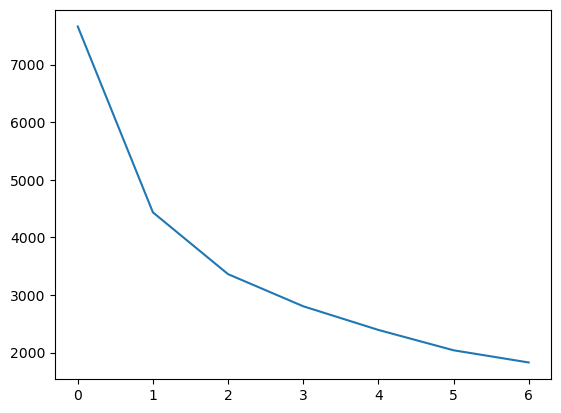

In [30]:
# elbow curve / sum of squared distance 
range_n_clusters = [2, 3, 4 ,5, 6, 7, 8]
ssd = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter= 50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
    
plt.plot(ssd)
plt.show()

## Silhouette Analysis 

In [31]:
range_n_clusters = [2, 3, 4 ,5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # initalize k means 
    kmeans = KMeans(n_clusters= num_clusters, max_iter= 50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    #silhouette score
    silhoutte_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters = {}, the silhouette score is {}".format(num_clusters, silhoutte_avg))

For n_clusters = 2, the silhouette score is 0.5415858652525395
For n_clusters = 3, the silhouette score is 0.5084896296141937
For n_clusters = 4, the silhouette score is 0.47869076802882204
For n_clusters = 5, the silhouette score is 0.4654107583311566
For n_clusters = 6, the silhouette score is 0.4171700614092766
For n_clusters = 7, the silhouette score is 0.4163004085411908
For n_clusters = 8, the silhouette score is 0.4062717353719045


In [32]:
# final model with k = 3

kmeans = KMeans(n_clusters= 3, max_iter= 50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [33]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [34]:
# assigning the lables to the customer id

grouped_df['ClusterID'] = kmeans.labels_
grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot: xlabel='ClusterID', ylabel='Amount'>

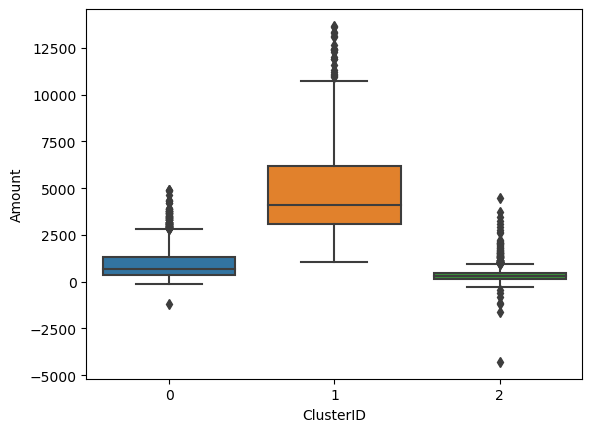

In [35]:
# plot
sns.boxplot(x = 'ClusterID', y = 'Amount', data = grouped_df)

In [36]:
# amount is cluster 1 and  2 is very lesser in comparison to the cluster number 2

<AxesSubplot: xlabel='ClusterID', ylabel='Recency'>

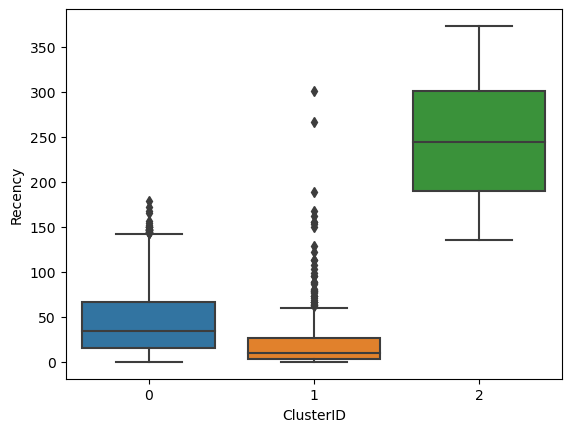

In [37]:

# lets check recency

sns.boxplot(x = 'ClusterID', y = 'Recency', data = grouped_df)

<AxesSubplot: xlabel='ClusterID', ylabel='Frequency'>

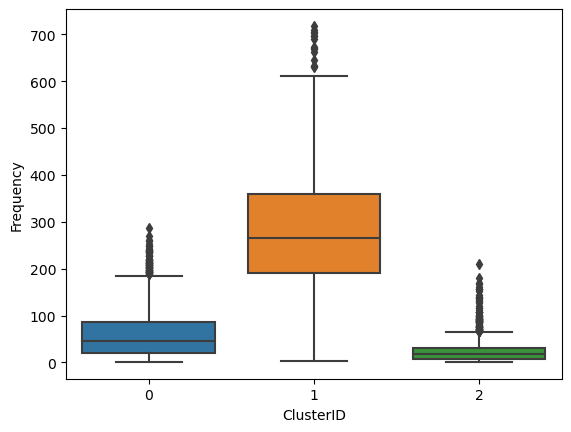

In [38]:
sns.boxplot(x = 'ClusterID', y = 'Frequency', data = grouped_df)